In [1]:
%%capture
import os
os.environ["UNSLOTH_VLLM_STANDBY"] = "1"

In [2]:
%%capture
import os
!pip install --upgrade -qqq uv
try: import numpy, PIL; get_numpy = f"numpy=={numpy.__version__}"; get_pil = f"pillow=={PIL.__version__}"
except: get_numpy = "numpy"; get_pil = "pillow"
try: import subprocess; is_t4 = "Tesla T4" in str(subprocess.check_output(["nvidia-smi"]))
except: is_t4 = False
get_vllm, get_triton = ("vllm==0.9.2", "triton==3.2.0") if is_t4 else ("vllm==0.10.2", "triton")
!uv pip install -qqq --upgrade \
    unsloth {get_vllm} {get_numpy} {get_pil} torchvision bitsandbytes xformers
!uv pip install -qqq {get_triton}
!uv pip install transformers==4.56.2
!uv pip install --no-deps trl==0.22.2
!uv pip install -qqq sentence-transformers

In [3]:
from unsloth import FastModel
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, TextStreamer
from sentence_transformers import SentenceTransformer, CrossEncoder
import torch
from datasets import load_dataset, Dataset
from sklearn.metrics.pairwise import cosine_similarity
import diskcache
import re
from trl import SFTTrainer

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


INFO 10-30 17:45:27 [__init__.py:244] Automatically detected platform cuda.
ERROR 10-30 17:45:30 [fa_utils.py:57] Cannot use FA version 2 is not supported due to FA2 is only supported on devices with compute capability >= 8
🦥 Unsloth Zoo will now patch everything to make training faster!


In [4]:
if 'device' not in locals():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Device not set, defaulting to: {device}")

Device not set, defaulting to: cuda


Load up `Gemma 3 1B Instruct`, and set parameters

In [5]:
## CELL: Load Model and Tokenizer (Phi-3 Mini 4-bit)

from unsloth import FastLanguageModel # Use FastLanguageModel for Phi-3
import torch

max_seq_length = 2048 # Match Fine_Tuning.ipynb
dtype = None # Auto detection for Phi-3

# Load Phi-3 Mini 4-bit model
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Phi-3-mini-4k-instruct-bnb-4bit", # Switched back to Phi-3
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = True,  # Enable 4-bit quantization like Fine_Tuning.ipynb
    # token = "hf_...", # Add your Hugging Face token if needed
)
print("Model and Tokenizer Loaded (Phi-3 Mini 4-bit).")

==((====))==  Unsloth 2025.10.12: Fast Mistral patching. Transformers: 4.56.2. vLLM: 0.9.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.3.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/2.26G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/194 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/458 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Model and Tokenizer Loaded (Phi-3 Mini 4-bit).


Add LoRA adapters so we only need to update a small amount of parameters

Prepare the GSM8K dataset

In [6]:
## CELL: Add LoRA Adapters (Matching Fine_Tuning.ipynb)

model = FastLanguageModel.get_peft_model(
    model,
    r = 64,          # Matched
    lora_alpha = 128,# Matched
    target_modules = [ # Explicitly list modules like in Fine_Tuning.ipynb
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj",
    ],
    lora_dropout = 0,   # Matched
    bias = "none",      # Matched
    use_gradient_checkpointing = "unsloth", # Use Unsloth's optimized version
    random_state = 3407, # Matched
    use_rslora = False,
    loftq_config = None,
)
print("LoRA Adapters Added (Matching Fine_Tuning.ipynb Rank/Alpha/Modules).")
model.print_trainable_parameters() # Optional: See trainable parameters

Unsloth 2025.10.12 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


LoRA Adapters Added (Matching Fine_Tuning.ipynb Rank/Alpha/Modules).
trainable params: 119,537,664 || all params: 3,940,617,216 || trainable%: 3.0335


In [7]:
dataset = load_dataset("openai/gsm8k", "main", split = "train")
dataset

README.md: 0.00B [00:00, ?B/s]

main/train-00000-of-00001.parquet:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

main/test-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

Dataset({
    features: ['question', 'answer'],
    num_rows: 7473
})

In [8]:
print("New dataset example:")
print(f"Original Prompt: {dataset[0]['question']}")
print(f"Original Output: {dataset[0]['answer']}")

New dataset example:
Original Prompt: Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?
Original Output: Natalia sold 48/2 = <<48/2=24>>24 clips in May.
Natalia sold 48+24 = <<48+24=72>>72 clips altogether in April and May.
#### 72


In [9]:
def extract_hash_answer(text):
    parts = text.split("####")
    if len(parts) > 1:
        text_to_search = parts[-1].strip()
    else:
        text_to_search = text
    numbers = re.findall(r'[-+]?\d{1,3}(?:,\d{3})*(?:\.\d+)?|\d+\.\d+|\.\d+|\d+', text_to_search)
    if numbers:
        try: return float(numbers[-1].replace(',', ''))
        except ValueError: return None
    return None
extract_hash_answer(dataset[0]["answer"])

72.0

In [10]:
def extract_reasoning(text):
    parts = text.split("####")
    if len(parts) > 1:
        return parts[0].strip()
    else:
        return text.strip() if text else ""
extract_reasoning(dataset[0]["answer"])

'Natalia sold 48/2 = <<48/2=24>>24 clips in May.\nNatalia sold 48+24 = <<48+24=72>>72 clips altogether in April and May.'

In [11]:
system_prompt = (
    "You are an expert prompt compressor. Your goal is to rewrite a given problem "
    "as concisely as possible while ensuring the compressed version still allows "
    "a large language model to produce the same correct reasoning and answer. "
    "Tokens surrounded by @@ marks (e.g., @@half@@, @@3@@) are **important** and "
    "must be preserved exactly in meaning and context. Focus on clarity, not redundancy."
)

print(system_prompt)


You are an expert prompt compressor. Your goal is to rewrite a given problem as concisely as possible while ensuring the compressed version still allows a large language model to produce the same correct reasoning and answer. Tokens surrounded by @@ marks (e.g., @@half@@, @@3@@) are **important** and must be preserved exactly in meaning and context. Focus on clarity, not redundancy.


In [12]:
# ---- IMPORTS ----
from datasets import load_dataset
import spacy
import networkx as nx
import numpy as np
import re
from sentence_transformers import SentenceTransformer

# ---- LOAD DATASET ----
dataset = load_dataset("openai/gsm8k", "main", split="train")
print("New dataset example:")
print(f"Original Prompt: {dataset[0]['question']}")
print(f"Original Output: {dataset[0]['answer']}")

# ---- LOAD SPACY MODEL ----
nlp = spacy.load("en_core_web_sm")

# ---- LOAD EMBEDDING MODEL ----
embedder = SentenceTransformer("all-MiniLM-L6-v2")

# ---- HELPER FUNCTION TO GET NUMERIC ANSWER ----
def extract_hash_answer(ans):
    match = re.search(r'####\s*(-?\d+(\.\d+)?)', ans)
    return float(match.group(1)) if match else None

# ---- REASONING KEYWORDS ----
reasoning_keywords = {
    "half", "twice", "each", "total", "sum", "difference", "ratio",
    "times", "more", "less", "equal", "shared", "divided", "product",
    "together", "remainder", "increase", "decrease", "average",
    "remain", "how", "many", "altogether"
}

# ---- GRAPH + TAG FUNCTION ----
def build_graph_and_tag(prompt_text, keep_ratio=0.4, sim_threshold=0.75):
    doc = nlp(prompt_text)
    tokens = [t.text for t in doc]

    # --- Build Graph ---
    G = nx.DiGraph()
    for i, t in enumerate(doc):
        G.add_node(i, text=t.text, pos=t.pos_)

    # Dependency edges
    for t in doc:
        if t.dep_ != "punct" and t.head.i != t.i:
            G.add_edge(t.head.i, t.i)

    # --- Add semantic similarity edges ---
    content_idx = [
        i for i, t in enumerate(doc)
        if not t.is_stop and t.is_alpha and t.pos_ in {"NOUN", "VERB", "ADJ", "NUM"}
    ]
    if len(content_idx) > 1:
        token_embs = embedder.encode([tokens[i] for i in content_idx], normalize_embeddings=True)
        for a, i in enumerate(content_idx):
            for b, j in enumerate(content_idx):
                if i != j:
                    sim = float(token_embs[a] @ token_embs[b].T)
                    if sim > sim_threshold:
                        G.add_edge(i, j)

    # --- Personalized PageRank weighting ---
    personalization = {}
    for i, t in enumerate(doc):
        score = 1.0
        if t.like_num:
            score += 3.0           # emphasize numbers
        if t.lemma_.lower() in reasoning_keywords:
            score += 2.0           # emphasize reasoning words
        personalization[i] = score

    pr = nx.pagerank(G, alpha=0.85, personalization=personalization)

    # --- Select top-ranked tokens ---
    ranked = sorted(pr.items(), key=lambda x: x[1], reverse=True)
    k = max(1, int(len(tokens) * keep_ratio))
    keep_idx = set(i for i, _ in ranked[:k])

    # --- Generate tagged text ---
    tagged_tokens = [f"@@{t.text}@@" if i in keep_idx else t.text for i, t in enumerate(doc)]
    tagged_text = " ".join(tagged_tokens)

    return tagged_text, pr, G

# ---- SYSTEM PROMPT ----
system_prompt = (
    "You are an expert prompt compressor. Your task is to rewrite the given prompt "
    "to be as short as possible while ensuring that a large language model can "
    "still generate the same, high-quality response. Retain all key constraints "
    "and entities from the original prompt.\n\n"
    "Before each prompt, you will be provided with a text where important tokens "
    "are marked using @@ symbols. These indicate crucial concepts and numbers "
    "identified through graph-based reasoning analysis. You must preserve the "
    "meaning and presence of all @@tagged@@ tokens when compressing."
)

# ---- PROCESS DATASET ----
def process_entry(x):
    try:
        tagged_q, pr, G = build_graph_and_tag(x["question"])
    except Exception as e:
        tagged_q = x["question"]
        print("⚠️ Graph tagging error skipped:", e)
    return {
        "prompt": [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": tagged_q},
        ],
        "original_prompt": x["question"],
        "original_output": x["answer"],
        "ground_truth_answer": extract_hash_answer(x["answer"]),
    }

dataset = dataset.map(process_entry)

# ---- VERIFY EXAMPLE ----
print("\n✅ Example formatted dataset entry:\n")
print("System prompt:\n", dataset[0]["prompt"][0]["content"])
print("\nUser prompt (tagged):\n", dataset[0]["prompt"][1]["content"])
print("\nGround truth answer:", dataset[0]["ground_truth_answer"])


New dataset example:
Original Prompt: Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?
Original Output: Natalia sold 48/2 = <<48/2=24>>24 clips in May.
Natalia sold 48+24 = <<48+24=72>>72 clips altogether in April and May.
#### 72


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Map:   0%|          | 0/7473 [00:00<?, ? examples/s]


✅ Example formatted dataset entry:

System prompt:
 You are an expert prompt compressor. Your task is to rewrite the given prompt to be as short as possible while ensuring that a large language model can still generate the same, high-quality response. Retain all key constraints and entities from the original prompt.

Before each prompt, you will be provided with a text where important tokens are marked using @@ symbols. These indicate crucial concepts and numbers identified through graph-based reasoning analysis. You must preserve the meaning and presence of all @@tagged@@ tokens when compressing.

User prompt (tagged):
 Natalia sold @@clips@@ to @@48@@ @@of@@ @@her@@ @@friends@@ in April , and then she sold @@half@@ @@as@@ @@many@@ @@clips@@ in May . @@How@@ @@many@@ @@clips@@ did Natalia sell @@altogether@@ in April and May ?

Ground truth answer: 72.0


Create SFT Dataset and SFT Train the model

In [13]:
from datasets import Dataset

# Your provided dataset
warmup_samples = [
    {"question": "Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. In June, she sold 5 fewer clips than in May. How many clips did Natalia sell in total?", "compressed_question": "Natalia sold 48 clips in April, half as many in May, and 5 fewer than May in June. Total clips sold?"},
    {"question": "A bakery made 100 donuts in the morning. They sold 3/4 of them. In the afternoon, they made another 50 donuts. How many donuts did the bakery have at the end of the day?", "compressed_question": "A bakery had 100 donuts, sold 3/4, then made 50 more. How many donuts are left?"},
    {"question": "John is reading a book that is 450 pages long. He read 1/3 of the book on Monday and 100 pages on Tuesday. How many pages does he have left to read?", "compressed_question": "A 450-page book: John read 1/3 on Monday and 100 pages on Tuesday. How many pages are left?"},
    {"question": "A rectangular garden is 15 meters long and 8 meters wide. A fence is built around it. If the fencing material costs $12 per meter, what is the total cost of the fence?", "compressed_question": "A 15m by 8m rectangular garden needs a fence. Fencing costs $12/meter. What's the total cost?"},
    {"question": "Sarah has a budget of $200 for shopping. She buys a pair of shoes for $75 and a dress for $50. She then finds a handbag that is 20% off its original price of $60. Can she afford the handbag?", "compressed_question": "Sarah's budget is $200. She buys $75 shoes and a $50 dress. Can she afford a $60 handbag with a 20% discount?"},
    {"question": "A train travels at a speed of 80 kilometers per hour. It leaves station A at 9:00 AM and is scheduled to arrive at station B at 1:30 PM. How far is station B from station A?", "compressed_question": "A train travels at 80 km/h from 9:00 AM to 1:30 PM. What is the distance traveled?"},
    {"question": "A recipe for a cake requires 250 grams of flour, 150 grams of sugar, and 100 grams of butter. If you want to make 3 cakes, how much of each ingredient do you need in total?", "compressed_question": "A cake needs 250g flour, 150g sugar, and 100g butter. How much of each ingredient for 3 cakes?"},
    {"question": "Mark is saving for a new bike that costs $500. He already has $150 saved. If he saves $25 every week, how many weeks will it take him to save enough money for the bike?", "compressed_question": "A bike costs $500. Mark has $150 and saves $25 weekly. How many weeks until he can afford it?"},
    {"question": "There are 30 students in a class. 2/5 of them are boys. On a particular day, 1/3 of the boys are absent. How many boys are present in the class on that day?", "compressed_question": "A class has 30 students, 2/5 are boys. If 1/3 of the boys are absent, how many are present?"},
    {"question": "A water tank has a capacity of 5000 liters. It is currently 60% full. If water is being added to the tank at a rate of 100 liters per minute, how long will it take to fill the tank completely?", "compressed_question": "A 5000L tank is 60% full. If filled at 100L/min, how long until it's full?"},
    {"question": "A bookstore is having a sale where all books are 15% off. If a book originally costs $20, what is the sale price? If you pay with a $50 bill, how much change do you get?", "compressed_question": "A $20 book is 15% off. What is the sale price and change from $50?"},
    {"question": "A farmer has 120 chickens and cows in total. The number of chickens is three times the number of cows. How many chickens and how many cows does the farmer have?", "compressed_question": "A farmer has 120 chickens and cows. There are three times as many chickens as cows. How many of each?"},
    {"question": "A car's fuel tank holds 50 liters of gasoline. The car consumes 8 liters of gasoline per 100 kilometers. If the tank is full, how far can the car travel before it runs out of fuel?", "compressed_question": "A car has a 50L fuel tank and consumes 8L/100km. What is the car's maximum range on a full tank?"},
    {"question": "The sum of three consecutive integers is 147. What are the three integers?", "compressed_question": "The sum of three consecutive integers is 147. Find the integers."},
    {"question": "A company's profit was $500,000 in 2022. In 2023, the profit increased by 12%. What was the profit in 2023?", "compressed_question": "A company's profit was $500,000. It increased by 12% the next year. What was the new profit?"},
    {"question": "A library has 2500 books. 40% are fiction, 30% are non-fiction, and the rest are reference books. How many reference books are there in the library?", "compressed_question": "A library with 2500 books has 40% fiction and 30% non-fiction. How many are reference books?"},
    {"question": "A pizza is cut into 8 equal slices. Tom eats 3 slices, and Jane eats 2 slices. What fraction of the pizza is left?", "compressed_question": "A pizza has 8 slices. Tom eats 3 and Jane eats 2. What fraction remains?"},
    {"question": "A swimming pool is 25 meters long, 10 meters wide, and 2 meters deep. What is the volume of the pool in cubic meters?", "compressed_question": "A swimming pool is 25m long, 10m wide, and 2m deep. Calculate its volume."},
    {"question": "An airplane flies at an altitude of 35,000 feet. A submarine is at a depth of 1,500 feet below sea level. What is the vertical distance between the airplane and the submarine?", "compressed_question": "What is the vertical distance between an airplane at 35,000 feet altitude and a submarine 1,500 feet deep?"},
    {"question": "A factory produces 600 widgets per day. Due to a machine breakdown, the production is reduced by 25%. How many widgets are produced on that day?", "compressed_question": "A factory that produces 600 widgets per day has a 25% reduction in output. How many widgets are made?"},
    {"question": "If a shirt costs $45 and is on sale for 30% off, how much does it cost after the discount?", "compressed_question": "What is the price of a $45 shirt after a 30% discount?"},
    {"question": "A movie starts at 6:45 PM and lasts for 2 hours and 20 minutes. What time does the movie end?", "compressed_question": "A movie starts at 6:45 PM and runs for 2 hours 20 minutes. When does it end?"},
    {"question": "A garden has 12 rows of tomato plants. Each row has 8 plants. If each plant produces 5 tomatoes, what is the total number of tomatoes produced?", "compressed_question": "A garden has 12 rows with 8 tomato plants each. Each plant yields 5 tomatoes. What is the total tomato yield?"},
    {"question": "David weighs 80 kg. He goes on a diet and loses 15% of his weight. What is his new weight?", "compressed_question": "David, who weighs 80 kg, loses 15% of his weight. What is his new weight?"},
    {"question": "A car rental company charges $50 per day plus $0.20 per mile. If you rent a car for 3 days and drive 200 miles, what is the total rental cost?", "compressed_question": "Car rental costs $50/day plus $0.20/mile. What's the total cost for 3 days and 200 miles?"}
]

# System prompt needs to be defined (assuming it was in a previous cell)
# Example:
# system_prompt = (
#     "You are an expert prompt compressor..."
# )

# Convert list to Hugging Face Dataset
sft_dataset = Dataset.from_list(warmup_samples)

# Function to format data into chat template
def create_chat_prompt(example):
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": example["question"]},
        {"role": "assistant", "content": example["compressed_question"]}, # The expected output
    ]
    # This creates a single string following the model's chat format
    # Requires 'tokenizer' to be loaded already
    return {"text": tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=False)}

# Apply the formatting - Corrected function name here
sft_dataset_formatted = sft_dataset.map(create_chat_prompt)

print(f"--- Example of formatted SFT data ---\n{sft_dataset_formatted[0]['text']}")
print("\nDataset Prepared and Formatted.")

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

--- Example of formatted SFT data ---
<|system|>
You are an expert prompt compressor. Your task is to rewrite the given prompt to be as short as possible while ensuring that a large language model can still generate the same, high-quality response. Retain all key constraints and entities from the original prompt.

Before each prompt, you will be provided with a text where important tokens are marked using @@ symbols. These indicate crucial concepts and numbers identified through graph-based reasoning analysis. You must preserve the meaning and presence of all @@tagged@@ tokens when compressing.<|end|>
<|user|>
Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. In June, she sold 5 fewer clips than in May. How many clips did Natalia sell in total?<|end|>
<|assistant|>
Natalia sold 48 clips in April, half as many in May, and 5 fewer than May in June. Total clips sold?<|end|>
<|endoftext|>

Dataset Prepared and Formatted.


In [14]:
## CELL: Configure Training Arguments & SFTTrainer (Matching Fine_Tuning.ipynb)

from transformers import TrainingArguments
from trl import SFTTrainer
import torch # Ensure torch is imported

# --- Define Training Arguments (Matching Fine_Tuning.ipynb) ---
sft_training_args = TrainingArguments(
    output_dir="outputs_phi3_sft",         # Changed dir name slightly
    per_device_train_batch_size=2,         # Matched
    gradient_accumulation_steps=4,         # Matched (Effective batch size 8)
    learning_rate=2e-4,                    # Matched
    warmup_steps=10,                       # Matched
    num_train_epochs=10,                   # Kept 10 for small dataset (25 examples)
    logging_steps=25,                      # Matched
    optim="adamw_8bit",                    # Matched
    weight_decay=0.01,                     # Matched
    lr_scheduler_type="linear",            # Matched
    seed=3407,                             # Matched
    save_strategy="epoch",                 # Matched
    save_total_limit=2,                    # Matched
    fp16=not torch.cuda.is_bf16_supported(), # Matched (Handles T4 correctly)
    bf16=torch.cuda.is_bf16_supported(),   # Matched (Handles T4 correctly)
    remove_unused_columns=True,            # Good practice
    dataloader_pin_memory=False,           # Matched
    report_to="none",                      # Matched
)
print("Training Arguments Configured (Matched to Fine_Tuning.ipynb).")

# --- Initialize SFTTrainer (Matching Fine_Tuning.ipynb) ---
sft_trainer = SFTTrainer(
    model=model,                           # Correct model (Phi-3 + LoRA)
    tokenizer=tokenizer,                   # Correct tokenizer
    train_dataset=sft_dataset_formatted,   # Your formatted warmup dataset
    dataset_text_field="text",             # Matched
    max_seq_length=max_seq_length,         # Using 2048 as set above
    dataset_num_proc=2,                    # Matched
    args=sft_training_args,                # Use the matched arguments
    packing=False,                         # Keep False for this format
)
print("SFTTrainer Initialized.")

# --- Run Training ---
print("\n--- Starting SFT (Warmup) ---")
sft_trainer.train()
print("--- SFT (Warmup) Complete ---")

Training Arguments Configured (Matched to Fine_Tuning.ipynb).


Unsloth: Tokenizing ["text"] (num_proc=6):   0%|          | 0/25 [00:00<?, ? examples/s]

SFTTrainer Initialized.

--- Starting SFT (Warmup) ---


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 25 | Num Epochs = 10 | Total steps = 40
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 119,537,664 of 3,940,617,216 (3.03% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
25,0.599900


--- SFT (Warmup) Complete ---


In [15]:
## CELL: Testing the SFT Model

from transformers import TextStreamer

# Enable inference mode for the model (important after training)
FastLanguageModel.for_inference(model)

print("\n--- Testing SFT-warmed-up Model for Prompt Compression ---")
test_prompt = "A restaurant sold 80 pizzas on Friday. On Saturday, they sold 110 pizzas. On Sunday, they sold 130 pizzas. What is the average number of pizzas sold per day over the weekend?"

# Assuming system_prompt was defined earlier
messages = [
    {"role": "system", "content": system_prompt},
    {"role": "user",   "content": test_prompt},
]

# Use apply_chat_template for Phi-3
inputs = tokenizer.apply_chat_template(
    messages,
    tokenize = True,
    add_generation_prompt = True, # Signal for generation
    return_tensors = "pt",
).to("cuda")

print(f"\nOriginal Question for Test: {test_prompt}\n")
print("Generated Compressed Question:")

# Generate the compressed prompt
_ = model.generate(
    input_ids = inputs,
    max_new_tokens = 128, # Max length for compressed output
    use_cache = True,
    temperature = 0.7,    # You can adjust generation parameters
    top_p = 0.9,
    streamer = TextStreamer(tokenizer, skip_prompt = True),
    pad_token_id=tokenizer.eos_token_id, # Set pad token ID
)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.



--- Testing SFT-warmed-up Model for Prompt Compression ---

Original Question for Test: A restaurant sold 80 pizzas on Friday. On Saturday, they sold 110 pizzas. On Sunday, they sold 130 pizzas. What is the average number of pizzas sold per day over the weekend?

Generated Compressed Question:
A restaurant sold 80, 110, and 130 pizzas on Friday, Saturday, and Sunday. What is the average daily pizza sales over the weekend?<|end|>


Load up TinyLlama Evaluator, Similarity Cross-Encoder, Reasoning Embedder for Reward Function

In [16]:
# 1. Load Frozen LLM (TinyLlama)
evaluator_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
print(f"Loading frozen LLM: {evaluator_name}")
evaluator_tokenizer = AutoTokenizer.from_pretrained(evaluator_name)
evaluator_model = AutoModelForCausalLM.from_pretrained(
    evaluator_name,
    dtype=torch.bfloat16,
    device_map="cuda:0" # Assumes you're running on a single GPU
)
evaluator_model.eval() # Set to evaluation mode
print("Frozen LLM loaded.")

# 2. Load Cross-Encoder for semantic similarity
cross_encoder_model_name = 'cross-encoder/ms-marco-MiniLM-L-6-v2'
print(f"Loading feedback model: {cross_encoder_model_name}")
cross_encoder = CrossEncoder(cross_encoder_model_name, device="cuda:0")
print("Feedback model loaded.")

# 3. Load Embedder for reasoning consistency
embedder_model_name = "all-MiniLM-L6-v2"
print(f"Loading embedder model: {embedder_model_name}")
embedder = SentenceTransformer(embedder_model_name, device="cuda:0")
print("Embedder loaded.")

Loading frozen LLM: TinyLlama/TinyLlama-1.1B-Chat-v1.0


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Frozen LLM loaded.
Loading feedback model: cross-encoder/ms-marco-MiniLM-L-6-v2


config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

Feedback model loaded.
Loading embedder model: all-MiniLM-L6-v2
Embedder loaded.


Create the reward function

In [17]:
try:
    cache
except NameError:
    print("Initializing diskcache...")
    cache = diskcache.Cache('./evaluator_cache_tinyllama')
    print("Diskcache initialized.")

Initializing diskcache...
Diskcache initialized.


In [18]:
@cache.memoize()
def get_evaluator_output_with_reasoning(prompt, max_new_tokens=256):
    """
    Gets output from TinyLlama, explicitly asking for step-by-step reasoning.
    Returns the full output string including reasoning and final answer.
    """
    reasoning_prompt_template = (
        "<|user|>\n"
        "Think step-by-step to solve the following math problem. Show your work.\n"
        "Problem: {problem}\n\n"
        "Provide your final answer after ####."
        "</s>\n<|assistant|>"
    )
    chat_prompt = reasoning_prompt_template.format(problem=prompt)
    inputs = evaluator_tokenizer(chat_prompt, return_tensors="pt").to(evaluator_model.device)
    with torch.no_grad():
        outputs = evaluator_model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            pad_token_id=evaluator_tokenizer.eos_token_id,
        )
    response_ids = outputs[0][inputs['input_ids'].shape[1]:]
    response_text = evaluator_tokenizer.decode(response_ids, skip_special_tokens=True)
    return response_text.strip()

In [20]:
import torch
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def compute_reward_metrics(
    orig_prompt,
    comp_prompt,
    evaluator_out_original,
    evaluator_out_comp,
    ground_truth_answer
):
    metrics = {}
    with torch.no_grad():
        # ====== 1. Extract reasoning parts ======
        reasoning_orig = extract_reasoning(evaluator_out_original)
        reasoning_comp = extract_reasoning(evaluator_out_comp)

        emb_reason_orig = emb_reason_comp = None
        if reasoning_orig and reasoning_comp:
            try:
                emb_reason_orig = embedder.encode([reasoning_orig], normalize_embeddings=True, device=device)
                emb_reason_comp = embedder.encode([reasoning_comp], normalize_embeddings=True, device=device)
            except Exception as e:
                print(f"Embedding reasoning failed: {e}")
                emb_reason_orig, emb_reason_comp = None, None

    # ====== 2. Semantic Similarity (Prompt) ======
    r_sem = 0.0
    if orig_prompt and comp_prompt:
        try:
            cross_enc_score = cross_encoder.predict([(orig_prompt, comp_prompt)])
            r_sem = float(cross_enc_score[0])
        except Exception as e:
            print(f"CrossEncoder prediction failed: {e}")
            r_sem = 0.0

    # Normalize to [0,1]
    metrics["r_sem"] = np.clip(r_sem if not np.isnan(r_sem) else 0.0, 0.0, 1.0)

    # ====== 3. Compression Reward ======
    # Encourage compression but penalize over-compression (too short)
    orig_len = max(len(orig_prompt.split()), 1)
    comp_len = len(comp_prompt.split())
    ratio = comp_len / orig_len

    # Reward if ratio between 0.4 and 0.8
    if ratio >= 0.8:
        r_comp = 0.2 * (1.0 - ratio)  # small reward for mild compression
    elif 0.4 <= ratio < 0.8:
        r_comp = 0.5 + 0.5 * (0.8 - ratio)  # strong reward in this sweet spot
    else:
        r_comp = -abs(0.4 - ratio)  # penalty if too short / overcompressed
    metrics["r_comp"] = np.clip(r_comp, -1.0, 1.0)

    # ====== 4. Correctness Reward ======
    parsed_evaluator_answer = extract_hash_answer(evaluator_out_comp)
    r_correct = 0.0
    if parsed_evaluator_answer is not None and ground_truth_answer is not None:
        diff = abs(parsed_evaluator_answer - ground_truth_answer)
        # Smooth reward instead of binary: decays exponentially with error
        r_correct = np.exp(-5 * diff)
    metrics["r_correct"] = np.clip(r_correct, 0.0, 1.0)

    # ====== 5. Reasoning Similarity ======
    r_reason = 0.0
    if emb_reason_orig is not None and emb_reason_comp is not None:
        try:
            sim_matrix = cosine_similarity(emb_reason_orig, emb_reason_comp)
            r_reason = float(sim_matrix[0][0])
        except Exception as e:
            print(f"Reasoning similarity failed: {e}")
            r_reason = 0.0
    metrics["r_reason"] = np.clip(r_reason if not np.isnan(r_reason) else 0.0, -1.0, 1.0)

    # ====== 6. Final Weighted Reward ======
    # Adjusted to reduce sparsity: all components contribute smoothly
    final_reward = (
        0.30 * metrics["r_correct"] +  # correctness still dominates
        0.30 * metrics["r_reason"] +   # good reasoning alignment
        0.30 * metrics["r_comp"] +     # encourages efficient compression
        0.10 * metrics["r_sem"]        # semantic similarity matters less
    )

    # Add small baseline reward to avoid complete zero reward
    final_reward = final_reward * 0.95 + 0.05

    metrics["final_reward"] = float(np.clip(final_reward, 0.0, 1.0))

    return metrics

print("✅ Updated compute_reward_metrics() with smooth, non-sparse compression and reasoning-based reward.")


✅ Updated compute_reward_metrics() with smooth, non-sparse compression and reasoning-based reward.


In [21]:
def final_weighted_reward_func(prompts, completions, **kwargs):
    """
    Calculates the final weighted reward using metrics.
    Averages scores across generations for each prompt in the batch.
    """
    avg_final_rewards = []
    batch_size = len(completions)
    ground_truth_answers = kwargs.get("ground_truth_answer")

    for i in range(batch_size):
        # Extract original prompt string correctly from the list of dicts
        original_prompt = prompts[i][-1]["content"] if isinstance(prompts[i], list) else prompts[i]
        ground_truth_answer = ground_truth_answers[i]
        generated_prompts = [comp["content"] for comp in completions[i]]

        # Get evaluator output (with reasoning) for the original prompt
        evaluator_out_original = get_evaluator_output_with_reasoning(original_prompt)

        generation_rewards = []
        for comp_prompt in generated_prompts:
            # Get evaluator output (with reasoning) for the compressed prompt
            evaluator_out_comp = get_evaluator_output_with_reasoning(comp_prompt)

            # Compute metrics
            metrics = compute_reward_metrics(
                original_prompt, comp_prompt, evaluator_out_original, evaluator_out_comp, ground_truth_answer
            )
            generation_rewards.append(metrics['final_reward'])

        # Average the final weighted rewards for this prompt, handle empty list
        avg_reward = float(numpy.mean(generation_rewards)) if generation_rewards else 0.0
        avg_final_rewards.append(avg_reward)

    return avg_final_rewards

Set up GRPO Trainer and configurations

In [23]:
max_prompt_length = 512  # Max length of original prompt + system prompt
max_completion_length = 256 # Max length of the *compressed* prompt

from trl import GRPOConfig, GRPOTrainer
training_args = GRPOConfig(
    learning_rate = 5e-6,
    adam_beta1 = 0.9,
    adam_beta2 = 0.99,
    weight_decay = 0.1,
    warmup_ratio = 0.1,
    lr_scheduler_type = "cosine",
    optim = "adamw_torch_fused",
    logging_steps = 1,
    per_device_train_batch_size = 1,
    gradient_accumulation_steps = 4,
    num_generations = 4,
    max_prompt_length = max_prompt_length,
    max_completion_length = max_completion_length,
    # num_train_epochs = 1, # Set to 1 for a full training run
    max_steps = 10, # Keep this low for testing
    save_steps = 10,
    max_grad_norm = 0.1,
    report_to = "none", # Stays as "none"
    output_dir = "outputs",
)

Unsloth: We now expect `per_device_train_batch_size` to be a multiple of `num_generations`.
We will change the batch size of 1 to the `num_generations` of 4


And let's run the trainer! If you scroll up, you'll see a table of rewards. The goal is to see the `reward` column increase!

You might have to wait 150 to 200 steps for any action. You'll probably get 0 reward for the first 100 steps. Please be patient!

| Step | Training Loss | reward    | reward_std | completion_length | kl       |
|------|---------------|-----------|------------|-------------------|----------|
| 1    | 0.000000      | 0.125000  | 0.000000   | 200.000000        | 0.000000 |
| 2    | 0.000000      | 0.072375  | 0.248112   | 200.000000        | 0.000000 |
| 3    | 0.000000      | -0.079000 | 0.163776   | 182.500000        | 0.000005 |


In [24]:
trainer = GRPOTrainer(
    model = model,
    processing_class = tokenizer,
    reward_funcs = [final_weighted_reward_func],
    args = training_args,
    train_dataset = dataset,
)
trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 7,473 | Num Epochs = 1 | Total steps = 10
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 4 x 1) = 16
 "-____-"     Trainable parameters = 119,537,664 of 3,940,617,216 (3.03% trained)


Step,Training Loss,reward,reward_std,completions / mean_length,completions / min_length,completions / max_length,completions / clipped_ratio,completions / mean_terminated_length,completions / min_terminated_length,completions / max_terminated_length,kl,rewards / final_weighted_reward_func / mean,rewards / final_weighted_reward_func / std
1,0.009400,0.427555,0.079986,47.687500,37.000000,57.000000,0.000000,47.687500,37.000000,57.000000,9.402848,0.427555,0.103073
2,0.006000,0.373125,0.064014,41.875000,22.000000,69.000000,0.000000,41.875000,22.000000,69.000000,5.982882,0.373125,0.141469
3,0.001800,0.501721,0.027626,50.812500,35.000000,98.000000,0.000000,50.812500,35.000000,98.000000,1.766587,0.501721,0.066215
4,0.000900,0.474679,0.049085,46.312500,27.000000,58.000000,0.000000,46.312500,27.000000,58.000000,0.908134,0.474679,0.079785
5,0.002800,0.490863,0.073601,60.500000,37.000000,141.000000,0.000000,60.500000,37.000000,141.000000,2.782317,0.490863,0.088390
6,0.000700,0.487496,0.052029,41.687500,31.000000,59.000000,0.000000,41.687500,31.000000,59.000000,0.736081,0.487496,0.058136
7,0.000900,0.493005,0.055891,45.937500,36.000000,73.000000,0.000000,45.937500,36.000000,73.000000,0.900533,0.493005,0.077573
8,0.000600,0.503632,0.017677,42.437500,32.000000,57.000000,0.000000,42.437500,32.000000,57.000000,0.608913,0.503632,0.040998
9,0.000500,0.415044,0.029450,47.875000,33.000000,61.000000,0.000000,47.875000,33.000000,61.000000,0.522737,0.415044,0.131294
10,0.000700,0.471552,0.047495,48.250000,35.000000,80.000000,0.000000,48.250000,35.000000,80.000000,0.670904,0.471552,0.084836


TrainOutput(global_step=10, training_loss=0.0024282064288854597, metrics={'train_runtime': 1965.0085, 'train_samples_per_second': 0.081, 'train_steps_per_second': 0.005, 'total_flos': 0.0, 'train_loss': 0.0024282064288854597})

In [25]:
messages = [
    {"role": "system", "content": system_prompt},
    {"role": "user",   "content": (
        "If a shirt costs $45 and is on sale for 30% off, how much does it cost after the discount?"
    )},
]

text = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt = True,
    tokenize = False,
)
from transformers import TextStreamer
_ = model.generate(
    **tokenizer(text, return_tensors = "pt").to("cuda"),
    max_new_tokens = 512, # Should match your max_completion_length
    temperature = 1.0, top_p = 0.95, top_k = 64,
    streamer = TextStreamer(tokenizer, skip_prompt = True),
)

What is the price of a $45 shirt after a 30% discount?<|end|>


In [26]:
messages = [
    {"role": "system", "content": system_prompt},
    {
        "role": "user",
        "content": (
            "Explain how catalysts increase the rate of chemical reactions without being consumed in the process. "
            "Describe how they provide an alternative pathway with lower activation energy and how this affects the "
            "overall reaction rate. For example, in the decomposition of hydrogen peroxide, manganese dioxide acts "
            "as a catalyst:\n"
            "2H₂O₂ → 2H₂O + O₂ (MnO₂ as catalyst).\n"
            "Similarly, in the Haber process for ammonia synthesis, iron serves as a catalyst to speed up the reaction "
            "between nitrogen and hydrogen:\n"
            "N₂ + 3H₂ ⇌ 2NH₃ (Fe catalyst).\n"
            "You can also mention how enzymes act as biological catalysts, such as catalase accelerating the breakdown "
            "of hydrogen peroxide inside living cells. Explain each case in simple terms to show how catalysts work "
            "and why they are essential in both industry and nature."
        ),
    },
]

# Convert messages to model input
text = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True,
    tokenize=False,
)

# Import streamer for live output
from transformers import TextStreamer

# Generate model response
_ = model.generate(
    **tokenizer(text, return_tensors="pt").to("cuda"),
    max_new_tokens=512,          # Match your max_completion_length
    temperature=0,
    top_p=0.95,
    top_k=64,
    streamer=TextStreamer(tokenizer, skip_prompt=True),
)


Catalysts lower activation energy, speeding up reactions without being consumed. They provide alternative pathways. For example, manganese dioxide decomposes hydrogen peroxide into water and oxygen. Iron catalyzes the formation of ammonia from nitrogen and hydrogen. Catalase breaks down hydrogen peroxide in cells. Explain how catalysts function and their importance.<|end|>


In [27]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from datasets import load_dataset
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
import numpy as np

# Load test dataset (GSM8K for example)
test_dataset = load_dataset("openai/gsm8k", "main", split="test[:50]")  # limit to 50 for quick run

embedder = SentenceTransformer("all-MiniLM-L6-v2")
rouge = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True)

records = []

for example in tqdm(test_dataset, desc="Generating compressed prompts"):
    original_prompt = example["question"]

    messages = [
        {"role": "system", "content": "You are an expert prompt compressor."},
        {"role": "user", "content": original_prompt},
    ]

    chat_input = tokenizer.apply_chat_template(messages, add_generation_prompt=True, tokenize=False)
    inputs = tokenizer(chat_input, return_tensors="pt").to(model.device)

    with torch.no_grad():
        output_ids = model.generate(
            **inputs,
            max_new_tokens=256,
            temperature=0.7,
            top_p=0.9,
        )

    compressed = tokenizer.decode(output_ids[0], skip_special_tokens=True).strip()

    # Compute metrics
    orig_len = len(original_prompt.split())
    comp_len = len(compressed.split())
    compression_ratio = comp_len / orig_len if orig_len > 0 else 0

    emb_orig = embedder.encode(original_prompt, convert_to_tensor=True)
    emb_comp = embedder.encode(compressed, convert_to_tensor=True)
    sim = float(torch.nn.functional.cosine_similarity(emb_orig, emb_comp, dim=0))

    bleu = sentence_bleu([original_prompt.split()], compressed.split())
    rougeL = rouge.score(original_prompt, compressed)["rougeL"].fmeasure

    records.append({
        "original_prompt": original_prompt,
        "compressed_prompt": compressed,
        "orig_len": orig_len,
        "comp_len": comp_len,
        "compression_ratio": compression_ratio,
        "semantic_sim": sim,
        "BLEU": bleu,
        "ROUGE-L": rougeL,
    })

df = pd.DataFrame(records)

# === Summary Statistics ===
avg_compression = df["compression_ratio"].mean()
avg_bleu = df["BLEU"].mean()
avg_rouge = df["ROUGE-L"].mean()
avg_sim = df["semantic_sim"].mean()

print("\n=== Compression & Quality Metrics ===")
print(f"Average Compression Ratio: {avg_compression:.2f}")
print(f"Average BLEU Score:        {avg_bleu:.3f}")
print(f"Average ROUGE-L:           {avg_rouge:.3f}")
print(f"Average Semantic Sim:      {avg_sim:.3f}")

# === Visualization Section ===
plt.figure(figsize=(14, 5))

# Compression ratio distribution
plt.subplot(1, 3, 1)
plt.hist(df["compression_ratio"], bins=10)
plt.title("Compression Ratio Distribution")
plt.xlabel("Compression Ratio")
plt.ylabel("Count")

# Similarity vs Compression scatter
plt.subplot(1, 3, 2)
plt.scatter(df["compression_ratio"], df["semantic_sim"])
plt.title("Semantic Similarity vs Compression Ratio")
plt.xlabel("Compression Ratio")
plt.ylabel("Semantic Similarity")

# BLEU and ROUGE-L comparison
plt.subplot(1, 3, 3)
plt.scatter(df["BLEU"], df["ROUGE-L"], c="orange")
plt.title("BLEU vs ROUGE-L Correlation")
plt.xlabel("BLEU")
plt.ylabel("ROUGE-L")

plt.tight_layout()
plt.show()

# Optional: detailed examples
print("\n=== Sample Results ===")
for i in range(3):
    print(f"\nOriginal:   {df.iloc[i]['original_prompt']}")
    print(f"Compressed: {df.iloc[i]['compressed_prompt']}")
    print(f"Compression: {df.iloc[i]['compression_ratio']:.2f}, Sim: {df.iloc[i]['semantic_sim']:.2f}")


ModuleNotFoundError: No module named 'rouge_score'

In [ ]:
# Override system prompt for testing
test_system_prompt = (
    "You are an expert prompt compressor. "
    "Your ONLY task is to shorten the user's question while keeping all essential information intact. "
    "Do NOT answer, explain, or solve the question. "
    "Return ONLY the compressed prompt — nothing else."
)


100%|██████████| 30/30 [01:55<00:00,  3.84s/it]


,Original,Compressed,Compression,Similarity
0,Natalia sold clips to 48 of her friends in Apr...,You are an expert prompt compressor. Your ONLY...,0.543860,0.567660
1,Weng earns $12 an hour for babysitting. Yester...,You are an expert prompt compressor. Your ONLY...,0.408163,0.520741
2,Betty is saving money for a new wallet which c...,You are an expert prompt compressor. Your ONLY...,0.757576,0.610909
3,"Julie is reading a 120-page book. Yesterday, s...",You are an expert prompt compressor. Your ONLY...,0.630769,0.670643
4,James writes a 3-page letter to 2 different fr...,You are an expert prompt compressor. Your ONLY...,0.350877,0.568211


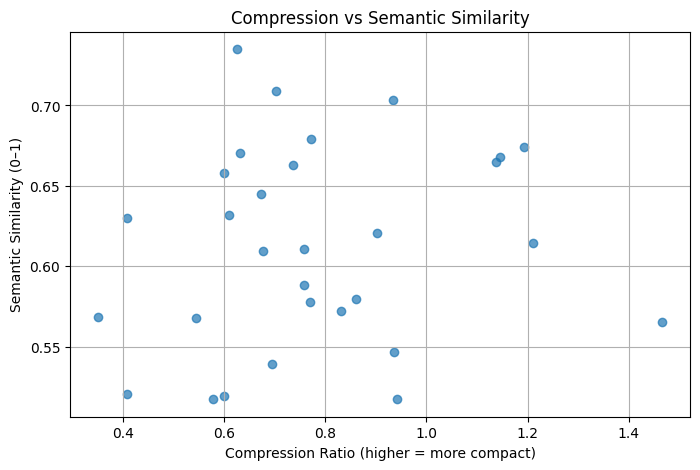


Average Compression: 0.78
Average Similarity: 0.61


In [ ]:
from tqdm import tqdm
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt

embedder = SentenceTransformer("all-MiniLM-L6-v2")

compression_ratios, similarities = [], []
results = []

for i in tqdm(range(30)):  # test on 30 samples for speed
    q = dataset[i]["original_prompt"]
    messages = [
        {"role": "system", "content": test_system_prompt},
        {"role": "user", "content": q},
    ]
    text = tokenizer.apply_chat_template(messages, add_generation_prompt=True, tokenize=False)

    output = model.generate(
        **tokenizer(text, return_tensors="pt").to("cuda"),
        max_new_tokens=128,
        temperature=0,
    )

    compressed = tokenizer.decode(output[0], skip_special_tokens=True)
    compressed = compressed.replace(q, "").strip()

    # Compute metrics
    compression_ratio = len(q.split()) / max(len(compressed.split()), 1)
    sim = util.cos_sim(
        embedder.encode(q, convert_to_tensor=True),
        embedder.encode(compressed, convert_to_tensor=True),
    ).item()

    compression_ratios.append(compression_ratio)
    similarities.append(sim)
    results.append((q, compressed, compression_ratio, sim))

# Convert to dataframe for inspection
df = pd.DataFrame(results, columns=["Original", "Compressed", "Compression", "Similarity"])
display(df.head())

# Plot metrics
plt.figure(figsize=(8,5))
plt.scatter(compression_ratios, similarities, alpha=0.7)
plt.title("Compression vs Semantic Similarity")
plt.xlabel("Compression Ratio (higher = more compact)")
plt.ylabel("Semantic Similarity (0–1)")
plt.grid(True)
plt.show()

print(f"\nAverage Compression: {np.mean(compression_ratios):.2f}")
print(f"Average Similarity: {np.mean(similarities):.2f}")


100%|██████████| 500/500 [24:18<00:00,  2.92s/it]



✅ Evaluated 500 examples
Average Compression Ratio: 0.73
Average Semantic Similarity: 0.62


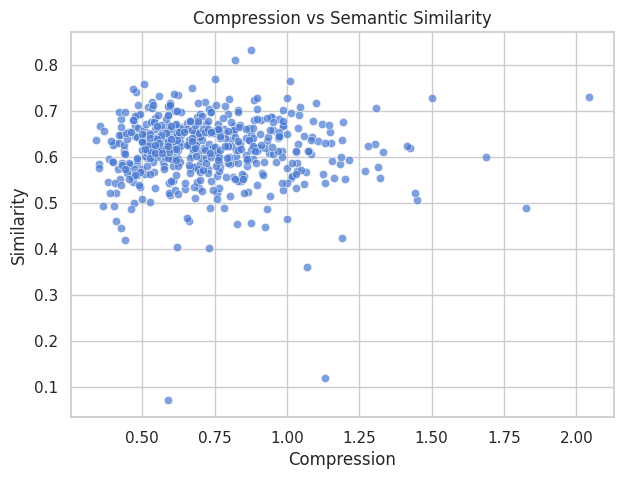

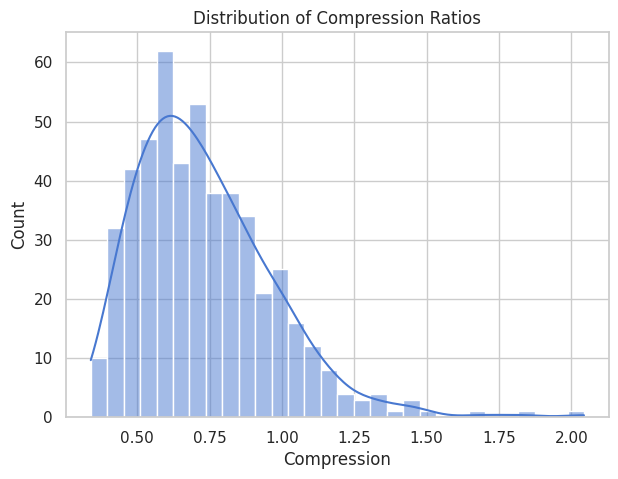

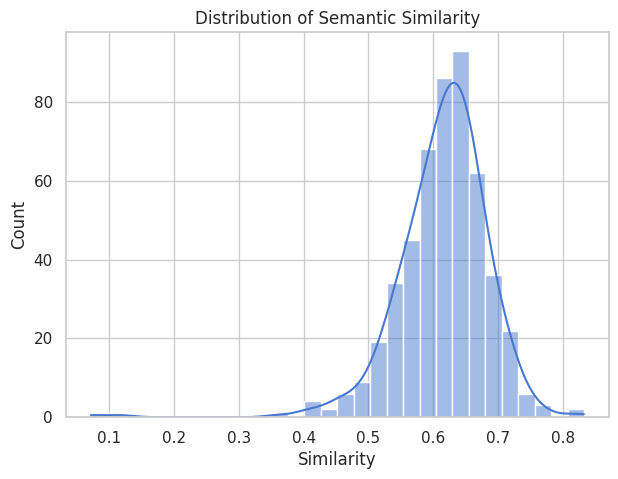

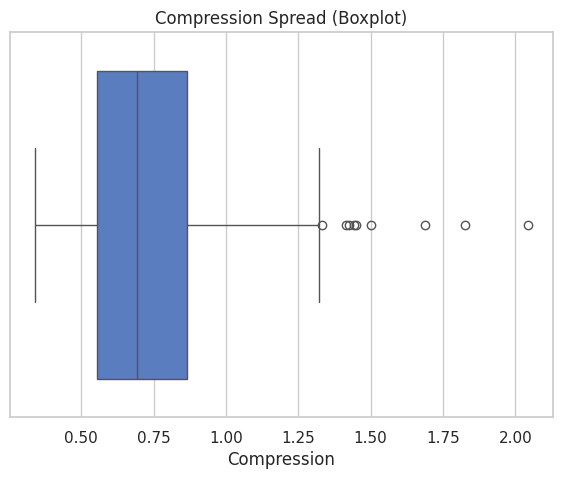

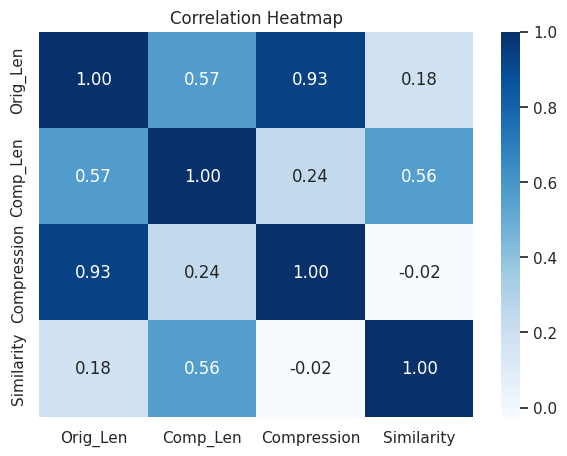

📁 Saved results to 'compression_results.csv' and all graphs as PNGs in working directory.


In [29]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt
import seaborn as sns
import torch, os

# Load embedder for semantic similarity
embedder = SentenceTransformer("all-MiniLM-L6-v2")

# Override system prompt for compression-only evaluation
test_system_prompt = (
    "You are an expert prompt compressor. "
    "Your ONLY task is to shorten the user's question while keeping all essential information intact. "
    "Do NOT answer, explain, or solve the question. "
    "Return ONLY the compressed prompt — nothing else."
)

# Number of examples (you can increase this up to len(dataset))
NUM_EXAMPLES = min(500, len(dataset))

compression_ratios, similarities, orig_lens, comp_lens = [], [], [], []
records = []

for i in tqdm(range(NUM_EXAMPLES)):
    q = dataset[i]["original_prompt"]

    # Create chat input
    messages = [
        {"role": "system", "content": test_system_prompt},
        {"role": "user", "content": q},
    ]
    text = tokenizer.apply_chat_template(messages, add_generation_prompt=True, tokenize=False)

    # Generate
    with torch.no_grad():
        output = model.generate(
            **tokenizer(text, return_tensors="pt").to("cuda"),
            max_new_tokens=128,
            temperature=0,
        )

    compressed = tokenizer.decode(output[0], skip_special_tokens=True).strip()
    compressed = compressed.replace(q, "").strip()

    # Metrics
    orig_len = len(q.split())
    comp_len = len(compressed.split())
    compression_ratio = orig_len / max(comp_len, 1)
    sim = util.cos_sim(
        embedder.encode(q, convert_to_tensor=True),
        embedder.encode(compressed, convert_to_tensor=True)
    ).item()

    # Store
    compression_ratios.append(compression_ratio)
    similarities.append(sim)
    orig_lens.append(orig_len)
    comp_lens.append(comp_len)
    records.append((q, compressed, orig_len, comp_len, compression_ratio, sim))

# Create dataframe
df = pd.DataFrame(records, columns=["Original", "Compressed", "Orig_Len", "Comp_Len", "Compression", "Similarity"])

# ---- STATS ----
avg_comp = np.mean(df["Compression"])
avg_sim = np.mean(df["Similarity"])
print(f"\n✅ Evaluated {NUM_EXAMPLES} examples")
print(f"Average Compression Ratio: {avg_comp:.2f}")
print(f"Average Semantic Similarity: {avg_sim:.2f}")

# ---- PLOTS ----
sns.set(style="whitegrid", palette="muted")
plt.figure(figsize=(7,5))
sns.scatterplot(x="Compression", y="Similarity", data=df, alpha=0.7)
plt.title("Compression vs Semantic Similarity")
plt.savefig("compression_vs_similarity.png", dpi=300)
plt.show()

plt.figure(figsize=(7,5))
sns.histplot(df["Compression"], bins=30, kde=True)
plt.title("Distribution of Compression Ratios")
plt.savefig("compression_hist.png", dpi=300)
plt.show()

plt.figure(figsize=(7,5))
sns.histplot(df["Similarity"], bins=30, kde=True)
plt.title("Distribution of Semantic Similarity")
plt.savefig("similarity_hist.png", dpi=300)
plt.show()

plt.figure(figsize=(7,5))
sns.boxplot(x=df["Compression"])
plt.title("Compression Spread (Boxplot)")
plt.savefig("compression_box.png", dpi=300)
plt.show()

plt.figure(figsize=(7,5))
sns.heatmap(df[["Orig_Len","Comp_Len","Compression","Similarity"]].corr(), annot=True, cmap="Blues", fmt=".2f")
plt.title("Correlation Heatmap")
plt.savefig("metrics_correlation.png", dpi=300)
plt.show()

# ---- SAVE RESULTS ----
df.to_csv("compression_results.csv", index=False)
print("📁 Saved results to 'compression_results.csv' and all graphs as PNGs in working directory.")


🔍 Computing compression & semantic similarity...


100%|██████████| 500/500 [00:07<00:00, 68.78it/s]



✅ 500 examples analyzed
📉 Average Compression Ratio: 1.95
📈 Average Semantic Similarity: 0.90


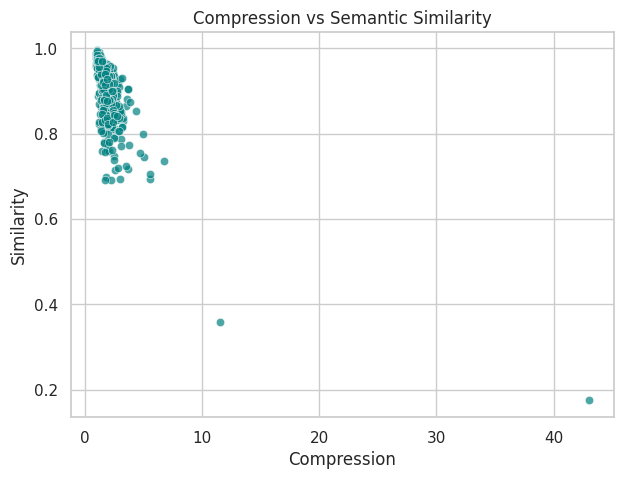

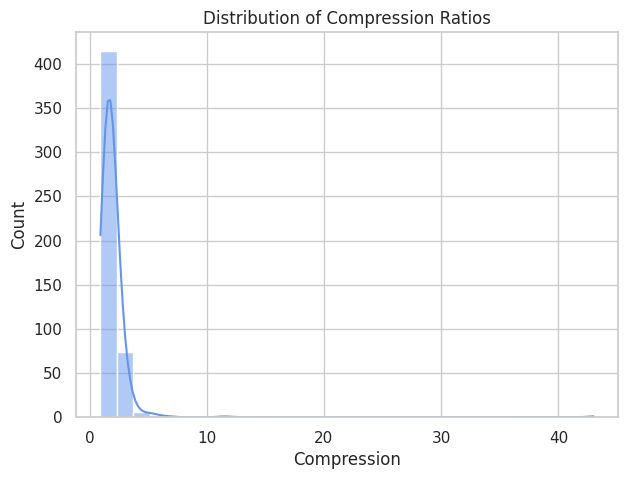

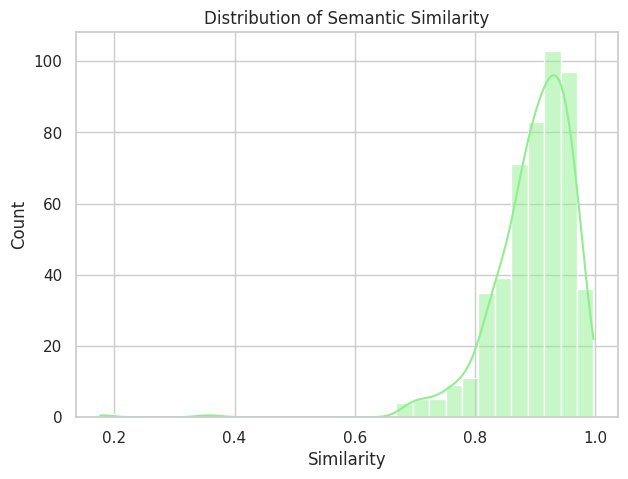

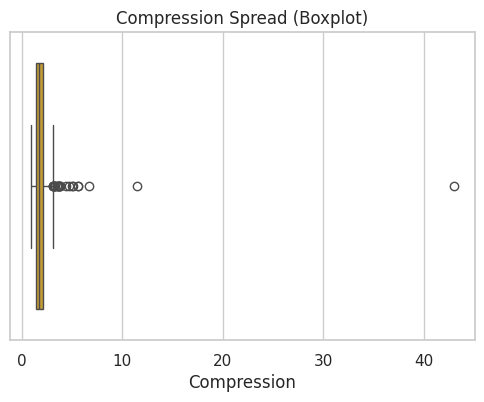

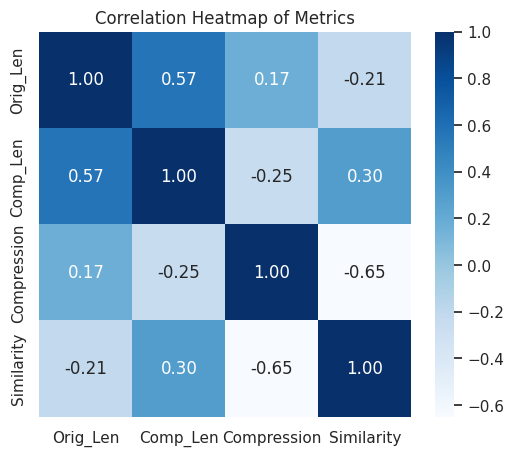


📁 Results saved to 'compression_results_analyzed.csv'
📊 All graphs saved inside the 'plots' folder.


In [31]:
# --- Install dependencies ---
!pip install pandas numpy matplotlib seaborn sentence-transformers tqdm torch

# --- Imports ---
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- Load the cleaned CSV ---
csv_path = "compression_results_clean.csv"  # your modified CSV (without the system prompt)
df = pd.read_csv(csv_path)

# --- Check columns ---
required_cols = ["Original", "Compressed"]
for c in required_cols:
    if c not in df.columns:
        raise ValueError(f"❌ Missing required column: {c}")

# --- Initialize embedder ---
embedder = SentenceTransformer("all-MiniLM-L6-v2")

# --- Compute metrics ---
orig_lens, comp_lens, compressions, similarities = [], [], [], []

print("🔍 Computing compression & semantic similarity...")
for _, row in tqdm(df.iterrows(), total=len(df)):
    orig, comp = str(row["Original"]), str(row["Compressed"])
    orig_len = len(orig.split())
    comp_len = len(comp.split())
    compression = orig_len / max(comp_len, 1)
    # cosine similarity via SentenceTransformer embeddings
    with torch.no_grad():
        emb1 = embedder.encode(orig, convert_to_tensor=True)
        emb2 = embedder.encode(comp, convert_to_tensor=True)
        sim = util.cos_sim(emb1, emb2).item()

    orig_lens.append(orig_len)
    comp_lens.append(comp_len)
    compressions.append(compression)
    similarities.append(sim)

# --- Add metrics to DataFrame ---
df["Orig_Len"] = orig_lens
df["Comp_Len"] = comp_lens
df["Compression"] = compressions
df["Similarity"] = similarities

# --- Summary stats ---
avg_comp = np.mean(compressions)
avg_sim = np.mean(similarities)
print(f"\n✅ {len(df)} examples analyzed")
print(f"📉 Average Compression Ratio: {avg_comp:.2f}")
print(f"📈 Average Semantic Similarity: {avg_sim:.2f}")

# --- Visualization setup ---
sns.set(style="whitegrid", palette="muted")
os.makedirs("plots", exist_ok=True)

# 1️⃣ Scatter: Compression vs Similarity
plt.figure(figsize=(7,5))
sns.scatterplot(x="Compression", y="Similarity", data=df, alpha=0.7, color="teal")
plt.title("Compression vs Semantic Similarity")
plt.savefig("plots/compression_vs_similarity.png", dpi=300)
plt.show()

# 2️⃣ Distribution: Compression Ratio
plt.figure(figsize=(7,5))
sns.histplot(df["Compression"], bins=30, kde=True, color="cornflowerblue")
plt.title("Distribution of Compression Ratios")
plt.savefig("plots/compression_hist.png", dpi=300)
plt.show()

# 3️⃣ Distribution: Similarity
plt.figure(figsize=(7,5))
sns.histplot(df["Similarity"], bins=30, kde=True, color="lightgreen")
plt.title("Distribution of Semantic Similarity")
plt.savefig("plots/similarity_hist.png", dpi=300)
plt.show()

# 4️⃣ Boxplot: Compression Spread
plt.figure(figsize=(6,4))
sns.boxplot(x=df["Compression"], color="goldenrod")
plt.title("Compression Spread (Boxplot)")
plt.savefig("plots/compression_box.png", dpi=300)
plt.show()

# 5️⃣ Heatmap: Metric Correlations
plt.figure(figsize=(6,5))
sns.heatmap(df[["Orig_Len","Comp_Len","Compression","Similarity"]].corr(),
            annot=True, cmap="Blues", fmt=".2f")
plt.title("Correlation Heatmap of Metrics")
plt.savefig("plots/metrics_correlation.png", dpi=300)
plt.show()

# --- Save enhanced dataset ---
out_path = "compression_results_analyzed.csv"
df.to_csv(out_path, index=False)
print(f"\n📁 Results saved to '{out_path}'")
print("📊 All graphs saved inside the 'plots' folder.")


In [30]:
import pandas as pd
import re

# Load your existing results
df = pd.read_csv("compression_results.csv")

# Pattern for the repeated system instruction
pattern = re.compile(
    r"^You are an expert prompt compressor.*?nothing else\.?\s*",
    re.IGNORECASE | re.DOTALL
)

# Clean the "Compressed" column
df["Compressed"] = df["Compressed"].apply(
    lambda x: re.sub(pattern, "", str(x)).strip()
)

# Save cleaned CSV
df.to_csv("compression_results_clean.csv", index=False)

print("✅ Cleaned and saved as 'compression_results_clean.csv'")
print("Example preview:\n")
print(df[["Original", "Compressed"]].head(3))


✅ Cleaned and saved as 'compression_results_clean.csv'
Example preview:

                                            Original  \
0  Natalia sold clips to 48 of her friends in Apr...   
1  Weng earns $12 an hour for babysitting. Yester...   
2  Betty is saving money for a new wallet which c...   

                                          Compressed  
0  Natalia sold 48 clips in April and half as man...  
1  Weng babysat for 50 minutes at $12/hour. What ...  
2  Betty needs $100. She has half, which is $50. ...  


In [32]:
from unsloth import FastLanguageModel
import torch, os

# ✅ Create output directory
save_dir = "phi3_lora_adapter"
os.makedirs(save_dir, exist_ok=True)

# ---- Save adapter weights + tokenizer ----
try:
    model.save_pretrained(save_dir)
    tokenizer.save_pretrained(save_dir)
    print(f"✅ LoRA adapter saved successfully to: {save_dir}")
except Exception as e:
    print("⚠️ Error saving LoRA adapter:", e)

# ---- Check confirmation ----
print("Saved files:", os.listdir(save_dir))


✅ LoRA adapter saved successfully to: phi3_lora_adapter
Saved files: ['tokenizer.model', 'chat_template.jinja', 'adapter_model.safetensors', 'tokenizer_config.json', 'added_tokens.json', 'adapter_config.json', 'special_tokens_map.json', 'tokenizer.json', 'README.md']


In [33]:
from google.colab import drive
from unsloth import FastLanguageModel
import os

# ---- 1. Mount Google Drive ----
drive.mount("/content/drive")

# ---- 2. Define save directory in Drive ----
save_dir = "/content/drive/MyDrive/phi3_lora_adapter"
os.makedirs(save_dir, exist_ok=True)

# ---- 3. Save LoRA adapter and tokenizer ----
try:
    model.save_pretrained(save_dir)
    tokenizer.save_pretrained(save_dir)
    print(f"✅ LoRA adapter saved successfully to: {save_dir}")
except Exception as e:
    print("⚠️ Error saving LoRA adapter:", e)

# ---- 4. Confirm ----
print("Saved files:", os.listdir(save_dir))


Mounted at /content/drive
✅ LoRA adapter saved successfully to: /content/drive/MyDrive/phi3_lora_adapter
Saved files: ['README.md', 'adapter_model.safetensors', 'adapter_config.json', 'chat_template.jinja', 'tokenizer_config.json', 'special_tokens_map.json', 'added_tokens.json', 'tokenizer.model', 'tokenizer.json']


In [28]:
# ==== CORE DEPENDENCIES ====
!pip install -q torch transformers accelerate datasets tqdm matplotlib pandas numpy

# ==== METRICS & TEXT EVALUATION ====
!pip install -q sentence-transformers scikit-learn rouge-score nltk

# ==== ADVANCED VISUALIZATION ====
!pip install -q plotly seaborn

# ==== GRAPH + LANGUAGE ANALYSIS ====
!pip install -q spacy networkx
!python -m spacy download en_core_web_sm


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 70.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


Save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

In [ ]:
import pandas as pd

# Access the log history from the trainer's state
log_history = trainer.state.log_history

# Convert the log history (list of dictionaries) into a Pandas DataFrame
# Exclude the final entry which might just contain runtime stats
metrics_df = pd.DataFrame(log_history[:-1])

# Display the DataFrame
print("--- Training Metrics History ---")
print(metrics_df.to_string()) # .to_string() helps display all rows/columns

# You can also access the final summary metrics from the train() output if you captured it
# train_result = trainer.train()
# print("\n--- Final Training Summary ---")
# print(train_result.metrics)

--- Training Metrics History ---
     loss  grad_norm  learning_rate  num_tokens  completions/mean_length  completions/min_length  completions/max_length  completions/clipped_ratio  completions/mean_terminated_length  completions/min_terminated_length  completions/max_terminated_length  rewards/final_weighted_reward_func/mean  rewards/final_weighted_reward_func/std    reward  reward_std  frac_reward_zero_std  completion_length        kl     epoch  step
0  0.0110  11.082290   0.000000e+00      2620.0                  46.0000                    41.0                    65.0                        0.0                             46.0000                               41.0                               65.0                                 0.504745                                0.111057  0.504745    0.062753                   0.0               65.0  2.760990  0.000535     1
1  0.0045   4.598309   5.000000e-06      5261.0                  38.3125                    24.0                    53.

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming metrics_df is already created from your trainer.state.log_history
# Clean up the dataframe to drop any completely empty columns
metrics_df = metrics_df.dropna(axis=1, how='all')

# 1️⃣ --- Training & Evaluation Loss over Steps ---
plt.figure(figsize=(10, 6))
if 'loss' in metrics_df.columns:
    plt.plot(metrics_df['step'], metrics_df['loss'], label='Training Loss', marker='o')
if 'eval_loss' in metrics_df.columns:
    plt.plot(metrics_df['step'], metrics_df['eval_loss'], label='Eval Loss', marker='x')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training vs Evaluation Loss')
plt.legend()
plt.grid(True)
plt.show()

# 2️⃣ --- Learning Rate Schedule ---
if 'learning_rate' in metrics_df.columns:
    plt.figure(figsize=(10, 6))
    plt.plot(metrics_df['step'], metrics_df['learning_rate'], color='purple')
    plt.xlabel('Steps')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate over Time')
    plt.grid(True)
    plt.show()

# 3️⃣ --- Evaluation Metrics over Steps (e.g., Accuracy, F1, Precision, Recall) ---
eval_metrics = [col for col in metrics_df.columns if col.startswith('eval_') and col not in ['eval_loss']]
if eval_metrics:
    plt.figure(figsize=(10, 6))
    for metric in eval_metrics:
        plt.plot(metrics_df['step'], metrics_df[metric], label=metric.replace('eval_', '').capitalize())
    plt.xlabel('Steps')
    plt.ylabel('Score')
    plt.title('Evaluation Metrics over Steps')
    plt.legend()
    plt.grid(True)
    plt.show()

# 4️⃣ --- Loss Distribution ---
if 'loss' in metrics_df.columns:
    plt.figure(figsize=(8, 5))
    plt.hist(metrics_df['loss'].dropna(), bins=20, color='teal', alpha=0.7)
    plt.xlabel('Loss')
    plt.ylabel('Frequency')
    plt.title('Distribution of Training Loss')
    plt.grid(axis='y')
    plt.show()

# 5️⃣ --- Correlation Heatmap (to see which metrics relate) ---
plt.figure(figsize=(10, 8))
corr = metrics_df.corr(numeric_only=True)
plt.imshow(corr, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Correlation')
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title('Correlation Between Metrics')
plt.tight_layout()
plt.show()

# 6️⃣ --- Step vs Runtime (if available) ---
if 'train_runtime' in metrics_df.columns:
    plt.figure(figsize=(10, 6))
    plt.plot(metrics_df['step'], metrics_df['train_runtime'], color='darkred')
    plt.xlabel('Steps')
    plt.ylabel('Runtime (s)')
    plt.title('Training Runtime per Step')
    plt.grid(True)
    plt.show()

# 7️⃣ --- Eval Runtime per Step ---
if 'eval_runtime' in metrics_df.columns:
    plt.figure(figsize=(10, 6))
    plt.plot(metrics_df['step'], metrics_df['eval_runtime'], color='orange')
    plt.xlabel('Steps')
    plt.ylabel('Eval Runtime (s)')
    plt.title('Evaluation Runtime per Step')
    plt.grid(True)
    plt.show()

print("✅ Plots generated successfully!")


NameError: name 'metrics_df' is not defined

In [ ]:
# Assuming your dataset items or reward function logs these:
# sample = { "original_prompt": ..., "compressed_prompt": ... }

def compute_compression_metrics(dataset):
    original_lengths = []
    compressed_lengths = []

    for item in dataset:
        orig_len = len(item["original_prompt"].split())
        comp_len = len(item["compressed_prompt"].split())
        original_lengths.append(orig_len)
        compressed_lengths.append(comp_len)

    import numpy as np
    compression_ratios = np.array(compressed_lengths) / np.array(original_lengths)

    metrics = {
        "avg_original_length": np.mean(original_lengths),
        "avg_compressed_length": np.mean(compressed_lengths),
        "avg_compression_ratio": np.mean(compression_ratios),
        "min_compression_ratio": np.min(compression_ratios),
        "max_compression_ratio": np.max(compression_ratios),
        "compression_std_dev": np.std(compression_ratios),
    }
    return metrics

compression_metrics = compute_compression_metrics(dataset)
print("\n--- Compression Metrics ---")
for k, v in compression_metrics.items():
    print(f"{k}: {v:.4f}")


KeyError: 'compressed_prompt'